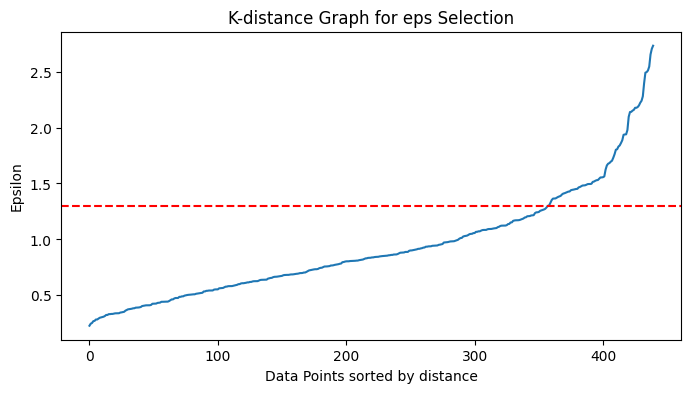

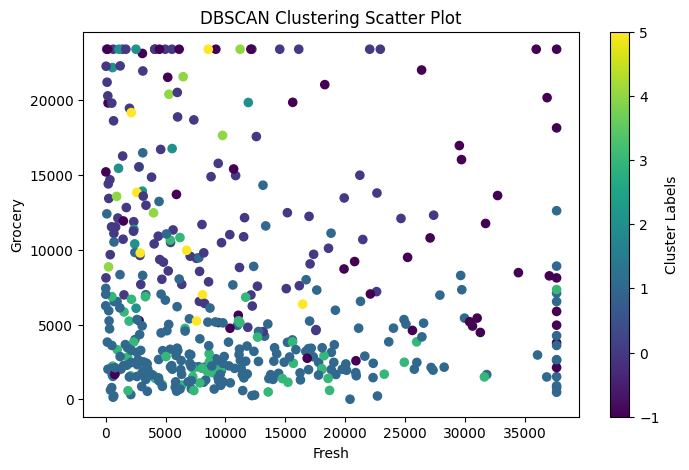

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# ==============================
# 1. LOAD DATASET
# ==============================

df = pd.read_csv("ML470_S8_Wholesale Customers data_Practice.csv")

# Exact numeric columns
cols = [
    "Channel", "Region", "Fresh", "Milk", "Grocery",
    "Frozen", "Detergents_Paper", "Delicassen"
]

df_num = df[cols].round(2)

# ==============================
# 2. OUTLIER TREATMENT (IQR)
# ==============================

def iqr_capping(data):
    capped = data.copy()
    for col in capped.columns:
        Q1 = capped[col].quantile(0.25)
        Q3 = capped[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        capped[col] = np.where(
            capped[col] < lower, lower,
            np.where(capped[col] > upper, upper, capped[col])
        )
    return capped.round(2)

df_capped = iqr_capping(df_num)

# ==============================
# 3. REMOVE HIGHLY CORRELATED FEATURES
# ==============================

corr = df_capped.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] >= 0.7)]
df_reduced = df_capped.drop(columns=to_drop)

# ==============================
# 4. STANDARDIZATION
# ==============================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_reduced)

# ==============================
# 5. K-DISTANCE GRAPH (5th NN)
# ==============================

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)

k_distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.axhline(y=1.3, color="red", linestyle="--")
plt.title("K-distance Graph for eps Selection")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("Epsilon")
plt.show()

# ==============================
# 6. DBSCAN CLUSTERING
# ==============================

dbscan = DBSCAN(eps=1.3, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# ==============================
# 7. CLUSTER VISUALIZATION (SAFE)
# ==============================
# NOTE: Use df_capped (not df_reduced)

plt.figure(figsize=(8, 5))
scatter = plt.scatter(
    df_capped["Fresh"],
    df_capped["Grocery"],
    c=labels,
    cmap="viridis",
    s=35
)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("DBSCAN Clustering Scatter Plot")
plt.xlabel("Fresh")
plt.ylabel("Grocery")
plt.show()
